In [1]:
import sys
from collections import defaultdict
import xlrd
import gurobipy as grb
from gurobipy import GRB

import numpy as np
import math

In [2]:
class Hotspot():
    def __init__(self, number, profits, area, uuv_obs_rate):
        self.number = number
        self.profits = profits
        self.area = area
        self.lam = uuv_obs_rate/area

In [3]:
def profit(idx, h_time):
    return (1 - math.exp(-lam[idx] * h_time))*max_reward[idx]

In [4]:
# # np.random.seed(248745) ##This works
# # np.random.seed(892486)
# # np.random.seed(2874905)
# # np.random.seed(187)
# np.random.seed(111849) ##This works

# distance = np.random.randint(0, 10000, size=(7,7))
# with open('./../santa_monica_energy_costs.npy', 'rb') as f:
#     transit_times = np.load(f)
# distance[1:, 1:] = transit_times[:,:,0]
# distance[0,0] = 99999999
# print (distance)

In [5]:
# distance = np.array([
# [99999999, 3062.320579, 5275.416425, 2793.626955, 3872.90992, 1521.450041, 4359.863797],
# [2580.558457, 99999999, 7110.817337, 515.0312469, 6251.249845, 3950.413872, 3566.632438],
# [5342.113429, 7701.365778, 99999999, 7733.152866, 5652.367252, 3803.566854, 5980.664648],
# [2400.739115, 603.2938988, 7236.22712, 99999999, 5915.524279, 3861.868201, 4049.86312],
# [4805.176336, 7687.54079, 6570.068057, 7255.255506, 99999999, 4131.191167, 8850.089379],
# [1674.122011, 4592.553567, 3909.644837, 4408.765148, 3314.121367, 99999999, 4811.699365],
# [3667.943709, 3349.095457, 5103.916382, 3755.353451, 7267.194692, 3936.579107, 99999999]])

# print (distance)

[[9.99999990e+07 3.06232058e+03 5.27541643e+03 2.79362696e+03
  3.87290992e+03 1.52145004e+03 4.35986380e+03]
 [2.58055846e+03 9.99999990e+07 7.11081734e+03 5.15031247e+02
  6.25124985e+03 3.95041387e+03 3.56663244e+03]
 [5.34211343e+03 7.70136578e+03 9.99999990e+07 7.73315287e+03
  5.65236725e+03 3.80356685e+03 5.98066465e+03]
 [2.40073911e+03 6.03293899e+02 7.23622712e+03 9.99999990e+07
  5.91552428e+03 3.86186820e+03 4.04986312e+03]
 [4.80517634e+03 7.68754079e+03 6.57006806e+03 7.25525551e+03
  9.99999990e+07 4.13119117e+03 8.85008938e+03]
 [1.67412201e+03 4.59255357e+03 3.90964484e+03 4.40876515e+03
  3.31412137e+03 9.99999990e+07 4.81169937e+03]
 [3.66794371e+03 3.34909546e+03 5.10391638e+03 3.75535345e+03
  7.26719469e+03 3.93657911e+03 9.99999990e+07]]


In [ ]:
# norm_distance_times = np.array([
# [99999999, 338, 2587, 698, 319, 1384, 413],
# [199, 99999999, 3779, 59, 285, 773, 1587],
# [2877, 3417, 99999999, 4117, 1684, 1743, 871],
# [460, 59, 2593, 99999999, 305, 376, 1554],
# [198, 442, 1730, 456, 99999999, 31, 135],
# [880, 951, 2065, 1200, 136, 99999999, 150],
# [358, 1491, 989, 1599, 4745, 90, 99999999]
# ])

In [28]:
norm_distance = np.array([
[9999999, 16900, 129350, 34900, 15950, 69200, 20650],
[9950, 9999999, 188950, 2950, 14250, 38650, 79350],
[143850, 170850, 9999999, 205850, 84200, 87150, 43550],
[23000, 2950, 129650, 9999999, 15250, 18800, 77700],
[9900, 22100, 86500, 22800, 9999999, 1550, 6750],
[44000, 47550, 103250, 60000, 6800, 9999999, 7500],
[17900, 74550, 49450, 79950, 237250, 4500, 9999999]
])
distance = (norm_distance)/50

In [34]:
astar_distance = np.array([
[9999999, 16900, 71700, 18200, 15950, 22300, 11750],
[9950, 9999999, 88550, 1250, 14250, 38650, 30900],
[82300, 96300, 9999999, 92350, 83150, 80750, 43550],
[23000, 1150, 85950, 9999999, 15250, 18800, 31000],
[9900, 22100, 56700, 22800, 9999999, 1550, 6750],
[18100, 47550, 49700, 36250, 6800, 9999999, 7500],
[11050, 25650, 49450, 24300, 7150, 4500, 9999999]
])

distance = (astar_distance)/50

In [19]:
# # distance = np.random.randint(0, 1000, size=(7,7))

# ##build all the hotspot data
# # np.random.seed(248745) ##This works
# # np.random.seed(892486)
# # np.random.seed(2874905)
# # np.random.seed(187)
# # np.random.seed(111849) ##This works
# np.random.seed(18)
# uuv_obs_rate = (3**2)*math.pi #arbitrarily selected observation rate
# all_hotspots = [Hotspot(0, 0, 99999999, uuv_obs_rate), ##This is the init position
#                 Hotspot(1, np.random.randint(0,100), np.random.randint(1000,5000), uuv_obs_rate),
#                 Hotspot(2, np.random.randint(0,100), np.random.randint(1000,5000), uuv_obs_rate),
#                 Hotspot(3, np.random.randint(0,100), np.random.randint(1000,5000), uuv_obs_rate),
#                 Hotspot(4, np.random.randint(0,100), np.random.randint(1000,5000), uuv_obs_rate),
#                 Hotspot(5, np.random.randint(0,100), np.random.randint(1000,5000), uuv_obs_rate),
#                 Hotspot(6, np.random.randint(0,100), np.random.randint(1000,5000), uuv_obs_rate),
#                 ]

In [101]:
# np.random.seed(374) ##This works
# # np.random.seed(18)
# uuv_obs_rate = (3**2)*math.pi #arbitrarily selected observation rate
# all_hotspots = [Hotspot(0, 0, 99999999, uuv_obs_rate), ##This is the init position
#                 Hotspot(1, np.random.randint(0,100), 11463, uuv_obs_rate),
#                 Hotspot(2, np.random.randint(0,100), 9432, uuv_obs_rate),
#                 Hotspot(3, np.random.randint(0,100), 7912, uuv_obs_rate),
#                 Hotspot(4, np.random.randint(0,100), 17487, uuv_obs_rate),
#                 Hotspot(5, np.random.randint(0,100), 19588, uuv_obs_rate),
#                 Hotspot(6, np.random.randint(0,100), 14637, uuv_obs_rate),
#                 ]

In [11]:
# uuv_obs_rate = (3**2)*math.pi #arbitrarily selected observation rate
# all_hotspots = [Hotspot(0, 0, 99999999, uuv_obs_rate), ##This is the init position
#                 Hotspot(1, 95, 11463, uuv_obs_rate),
#                 Hotspot(2, 89, 9432, uuv_obs_rate),
#                 Hotspot(3, 21, 7912, uuv_obs_rate),
#                 Hotspot(4, 72, 17487, uuv_obs_rate),
#                 Hotspot(5, 33, 19588, uuv_obs_rate),
#                 Hotspot(6, 57, 14637, uuv_obs_rate),
#                 ]

In [35]:
uuv_obs_rate = (3**2)*math.pi #arbitrarily selected observation rate
all_hotspots = [Hotspot(0, 0, 99999999, uuv_obs_rate), ##This is the init position
                Hotspot(1, 95, 11463, uuv_obs_rate),
                Hotspot(2, 89, 9432, uuv_obs_rate),
                Hotspot(3, 21, 7912, uuv_obs_rate),
                Hotspot(4, 72, 17487, uuv_obs_rate),
                Hotspot(5, 33, 19588, uuv_obs_rate),
                Hotspot(6, 57, 14637, uuv_obs_rate),
                ]

In [36]:
hotspot_idx = [i.number for i in all_hotspots]
points = [(i,j) for i in hotspot_idx for j in hotspot_idx]
max_reward = [i.profits for i in all_hotspots]
max_total_reward = sum(max_reward)
area = [i.area for i in all_hotspots]
lam = [i.lam for i in all_hotspots]
# Distance = 1800 # 30 mins
# Distance = 3000 # 50 mins
# Distance = 5400 # 1.5hrs
Distance = 2*60*60 #2hrs
# Distance = 10800 # 3 hrs
# Distance = 4*60*60 # 4hrs
# Distance = 12*60*60
# Distance = 240*60
# Distance = 240*60*50
n = len(all_hotspots)

In [37]:
print(lam)
print(area)
print (uuv_obs_rate)
print (max_reward)
print (max_total_reward)

print (uuv_obs_rate/area[1])

[2.827433416505148e-07, 0.002466573661546553, 0.002997702913730719, 0.003573601350140058, 0.0016168773307204288, 0.0014434518012205503, 0.00193170279991174]
[99999999, 11463, 9432, 7912, 17487, 19588, 14637]
28.274333882308138
[0, 95, 89, 21, 72, 33, 57]
367
0.002466573661546553


In [38]:
##SHIFT ONE DOWN

opt_model = grb.Model(name="MILP Model")

# <= Variables
##x_vars = x_ij travel from hotspot i to j
x_vars = {}
for i in range(n):
    for j in range(n):
        x_vars[i,j] = opt_model.addVar(vtype=grb.GRB.BINARY,
                          name='e'+str(i)+'_'+str(j))

##u = boolean if visit hotspot i
u={}
for i in range(1-1,n):
    u[i]=opt_model.addVar(vtype=grb.GRB.INTEGER,
                          name='e'+str(i))
    
##Introduce hotspot_time variable
##Create profits function
npts = 50000
ptf = np.empty((n, npts))
ptu = np.arange(0, npts, 1).tolist()

for i in range(0,n):
    for p in range(npts):
        ptf[i,p] = profit(i, ptu[p])

t={}
r={}
for i in range(1-1,n):
    t[i] = opt_model.addVar(lb = 0.0, ub = Distance, name='t'+str(i))
    r[i] = opt_model.addVar(lb = 0.0, ub = max_reward[i], name='r'+str(i))
    opt_model.addGenConstrPWL(t[i], r[i], ptu, ptf[i,:], "reward"+str(i))
    
for j in range(1-1,n):
    three = grb.quicksum([x_vars[i,j] for i in range(n-1)])
    opt_model.addConstr(three*500000 >= r[j])
    
    
# <= Constraint (Mandatory Edges and excluding vertexes) Eq(1) 
opt_model.addConstr(grb.quicksum([x_vars[1,j] for j in range(1-1,n)])  == 1)
opt_model.addConstr(grb.quicksum([x_vars[i,n-1] for i in range(n-1)])  == 1)

# <= Constraint (Distance) Eq(3)
opt_model.addConstr(grb.quicksum([x_vars[i,j]*t[j]
                                + x_vars[i,j]*distance[i,j] for j in range(1-1,n) for i in range(n-1)]) <= Distance)

# <= Constraint (Equality & Single edge in and out) Eq(2)
for k in range(1, n-1):
    one = grb.quicksum([x_vars[i,k] for i in range(n-1)])
    two = grb.quicksum([x_vars[k,j] for j in range(1-1, n)])
    opt_model.addConstr(one == two)
    opt_model.addConstr(one <= 1)

# <= Constraint (Subtour elimination) Eq(4) Eq(5)
for i in range(1-1,n):
    opt_model.addConstr(2 <= u[i])
    opt_model.addConstr(u[i] <= n)
    
for i in range(1-1,n):
    for j in range(1-1,n):
        opt_model.addConstr((u[i] - u[j] +1 <= (n-1)*(1-x_vars[j,i])))

        
# <= objective (maximize) Eq(1)
objective = grb.quicksum([x_vars[i,j]*r[j] 
                         for i in range(1-1, n-1)
                         for j in range(1-1, n)])

opt_model.ModelSense = grb.GRB.MAXIMIZE
opt_model.setObjective(objective)
opt_model.optimize()

solution = opt_model.getAttr('x', x_vars )
print (solution)

select = grb.tuplelist((i,j) for i,j in x_vars.keys() if x_vars[i,j].X > 0.5)
givemetime = grb.tuplelist((i, t[i].X) for i in t.keys() if t[i].X > 0.0)  ##amount of time spent at hotspot
givemereward = grb.tuplelist((i, r[i].X) for i in r.keys() if r[i].X > 0.0) ##amount of reward at hotspot?
print (select)
print (givemetime)
print (givemereward)

# d_givemetime = dict(givemetime)
# d_givemereward = dict(givemereward)

# total_time = 0
# total_profit = 0
# for z in range(len(select)):
# #     print ("z: ", z)
#     print ("select: ", select[z])
#     print ("path len: ", distance[select[z][0], select[z][1]])
#     total_time += distance[select[z][0], select[z][1]]

# print ("Total time spent on paths: ", total_time)
    
# for z in range(len(givemereward)):
# #     print ("hotspot reward: ", profit(givemereward[z][0], givemetime[z][1]))

#     print ("z: ", z)
#     print ("max_reward[z]   : ", max_reward[z[0]])
#     print ("givemereward[z] : ", givemereward[z[0]])
#     print ("givemetime[z]   : ", givemetime[z[0]])
#     print ("rounded profit  : ", round(profit(givemereward[z][0], givemetime[z][1])))

#     total_profit += round(profit(givemereward[z][0], givemetime[z][1]))
#     print ("hotspot time: ", givemetime[z][1])
#     total_time += givemetime[z][1]
    

# print ("TOTAL ANSWER IS : ", total_time)
# print ("TOTAL PROFIT IS: ", total_profit)
# print ("PERCENT COVERED: ", total_profit/max_total_reward)

Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (linux64)
Optimize a model with 82 rows, 70 columns and 294 nonzeros
Model fingerprint: 0xe6b67d8e
Model has 42 quadratic objective terms
Model has 1 quadratic constraint
Model has 7 general constraints
Variable types: 14 continuous, 56 integer (49 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+05]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [2e+01, 2e+05]
  Objective range  [0e+00, 0e+00]
  QObjective range [2e+00, 2e+00]
  Bounds range     [1e+00, 7e+03]
  RHS range        [1e+00, 7e+00]
  QRHS range       [7e+03, 7e+03]
Presolve added 0 rows and 50392 columns
Presolve removed 11 rows and 0 columns
Presolve time: 0.06s
Presolved: 170 rows, 50529 columns, 144531 nonzeros
Presolved model has 7 SOS constraint(s)
Variable types: 50487 continuous, 42 integer (36 binary)

Root relaxation: objective 3.670000e+02, 125 iterations, 0.08 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl 

In [39]:
print(dict(select))
print(givemereward)

d_select = dict(select)

spot = 0
order = []
for xx in range(len(select)):
    next_spot = d_select[spot]
    order.append(spot)
    spot = next_spot
order.append(spot)
    
d_time = dict(givemetime)
d_rew = dict(givemereward)

visited_paths = []
for o in range(len(order)-1):
    visited_paths.append(distance[order[o]][order[o+1]])
    
time_searching = []
rew = []
for o in order:
    if o == 0:
        continue
    time_searching.append(d_time[o])
    if o in d_rew:
        rew.append(d_rew[o])
    else:
        rew.append(0)

print ("Budget: ", Distance)
print ("Nodes visited : ", order)
print ("Path values taken: ", visited_paths)
# print ("Path values taken: ", np.array(visited_paths)/50)
print ("Time searching: ", time_searching)
print ("Reward        : ", rew)
print ("Total reward: ", sum(rew))
print ("Percentage    : ", sum(rew)/max_total_reward)

check = sum(np.array(visited_paths)) + sum(time_searching)
print ("check: ", check)

{0: 1, 1: 4, 2: 6, 4: 5, 5: 2}
<gurobi.tuplelist (6 tuples, 2 values each):
 ( 1 , 87.62197064240866     )
 ( 2 , 82.93402942146619     )
 ( 3 , 2.371378382956226e-07 )
 ( 4 , 60.76679565460738     )
 ( 5 , 20.399642204123772    )
 ( 6 , 47.599409038759596    )
>
Budget:  7200
Nodes visited :  [0, 1, 4, 5, 2, 6]
Path values taken:  [338.0, 285.0, 31.0, 994.0, 871.0]
Time searching:  [1035.9999999999998, 1149.0, 667.0, 896.0000000000001, 933.0000000000001]
Reward        :  [87.62197064240866, 60.76679565460738, 20.399642204123772, 82.93402942146619, 47.599409038759596]
Total reward:  299.3218469613656
Percentage    :  0.8155908636549472
check:  7200.0


In [124]:
np.random.seed(0)
[np.random.randint(0,100),np.random.randint(0,100), np.random.randint(0,100), np.random.randint(0,100), np.random.randint(0,100), np.random.randint(0,100)]

[44, 47, 64, 67, 67, 9]

In [ ]:
uuv_obs_rate = (3**2)*math.pi #arbitrarily selected observation rate

for seed in range(10):
    np.random.seed(seed)

    all_hotspots = [Hotspot(0, 0, 99999999, uuv_obs_rate), ##This is the init position
                    Hotspot(1, np.random.randint(0,100), 11463, uuv_obs_rate),
                    Hotspot(2, np.random.randint(0,100), 9432, uuv_obs_rate),
                    Hotspot(3, np.random.randint(0,100), 7912, uuv_obs_rate),
                    Hotspot(4, np.random.randint(0,100), 17487, uuv_obs_rate),
                    Hotspot(5, np.random.randint(0,100), 19588, uuv_obs_rate),
                    Hotspot(6, np.random.randint(0,100), 14637, uuv_obs_rate)]

    hotspot_idx = [i.number for i in all_hotspots]
    points = [(i,j) for i in hotspot_idx for j in hotspot_idx]
    max_reward = [i.profits for i in all_hotspots]
    max_total_reward = sum(max_reward)
    area = [i.area for i in all_hotspots]
    lam = [i.lam for i in all_hotspots]
    Distance = 180*60
    n = len(all_hotspots)

    ##SHIFT ONE DOWN

    opt_model = grb.Model(name="MILP Model")

    # <= Variables
    ##x_vars = x_ij travel from hotspot i to j
    x_vars = {}
    for i in range(n):
        for j in range(n):
            x_vars[i,j] = opt_model.addVar(vtype=grb.GRB.BINARY,
                              name='e'+str(i)+'_'+str(j))

    ##u = boolean if visit hotspot i
    u={}
    for i in range(1-1,n):
        u[i]=opt_model.addVar(vtype=grb.GRB.INTEGER,
                              name='e'+str(i))

    ##Introduce hotspot_time variable
    ##Create profits function
    npts = 50000
    ptf = np.empty((n, npts))
    ptu = np.arange(0, npts, 1).tolist()

    for i in range(0,n):
        for p in range(npts):
            ptf[i,p] = profit(i, ptu[p])

    t={}
    r={}
    for i in range(1-1,n):
        t[i] = opt_model.addVar(lb = 0.0, ub = Distance, name='t'+str(i))
        r[i] = opt_model.addVar(lb = 0.0, ub = max_reward[i], name='r'+str(i))
        opt_model.addGenConstrPWL(t[i], r[i], ptu, ptf[i,:], "reward"+str(i))

    for j in range(1-1,n):
        three = grb.quicksum([x_vars[i,j] for i in range(n-1)])
        opt_model.addConstr(three*5000 >= r[j])


    # <= Constraint (Mandatory Edges and excluding vertexes) Eq(1) 
    opt_model.addConstr(grb.quicksum([x_vars[1,j] for j in range(1-1,n)])  == 1)
    opt_model.addConstr(grb.quicksum([x_vars[i,n-1] for i in range(n-1)])  == 1)

    # <= Constraint (Distance) Eq(3)
    opt_model.addConstr(grb.quicksum([x_vars[i,j]*t[j]
                                    + x_vars[i,j]*distance[i,j] for j in range(1-1,n) for i in range(n-1)]) <= Distance)

    # <= Constraint (Equality & Single edge in and out) Eq(2)
    for k in range(1, n-1):
        one = grb.quicksum([x_vars[i,k] for i in range(n-1)])
        two = grb.quicksum([x_vars[k,j] for j in range(1-1, n)])
        opt_model.addConstr(one == two)
        opt_model.addConstr(one <= 1)

    # <= Constraint (Subtour elimination) Eq(4) Eq(5)
    for i in range(1-1,n):
        opt_model.addConstr(2 <= u[i])
        opt_model.addConstr(u[i] <= n)

    for i in range(1-1,n):
        for j in range(1-1,n):
            opt_model.addConstr((u[i] - u[j] +1 <= (n-1)*(1-x_vars[j,i])))


    # <= objective (maximize) Eq(1)
    objective = grb.quicksum([x_vars[i,j]*r[j] 
                             for i in range(1-1, n-1)
                             for j in range(1-1, n)])

    opt_model.ModelSense = grb.GRB.MAXIMIZE
    opt_model.setObjective(objective)
    opt_model.optimize()

    solution = opt_model.getAttr('x', x_vars )
#     print (solution)

    select = grb.tuplelist((i,j) for i,j in x_vars.keys() if x_vars[i,j].X > 0.5)
    givemetime = grb.tuplelist((i, t[i].X) for i in t.keys() if t[i].X > 0.0)  ##amount of time spent at hotspot
    givemereward = grb.tuplelist((i, r[i].X) for i in r.keys() if r[i].X > 0.0) ##amount of reward at hotspot?
#     print (select)
#     print (givemetime)
#     print (givemereward)
    
    d_select = dict(select)

    spot = 0
    order = []
    for xx in range(len(select)):
        next_spot = d_select[spot]
        order.append(spot)
        spot = next_spot
    order.append(spot)

    d_time = dict(givemetime)
    d_rew = dict(givemereward)

    visited_paths = []
    for o in range(len(order)-1):
        visited_paths.append(distance[order[o]][order[o+1]])

    time_searching = []
    rew = []
    for o in order:
        if o == 0:
            continue
        time_searching.append(d_time[o])
        if o in d_rew:
            rew.append(d_rew[o])
        else:
            rew.append(0)
            
    print ("Budget: ", Distance)
    print ("Nodes visited : ", order)
    print ("Path values taken: ", visited_paths)
    print ("Time searching: ", time_searching)
    print ("Reward        : ", rew)
    print ("Total reward: ", sum(rew))
    print ("Percentage    : ", sum(rew)/max_total_reward)

    check = sum(np.array(visited_paths)) + sum(time_searching)
    print ("check: ", check)

In [97]:
max_reward

[0, 95, 89, 72, 100, 64, 48]

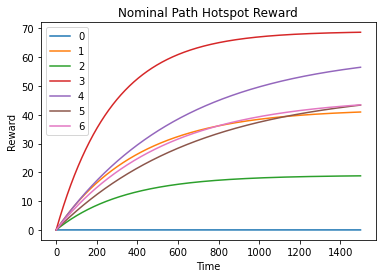

In [60]:
import matplotlib.pyplot as plt

x = np.arange(0, 1500)
fig = plt.plot()
for i in range(len(all_hotspots)):
    y = (1 - np.exp(-lam[i] * x)) * max_reward[i]
    plt.plot(x, y, label=i)

plt.ylabel('Reward')
plt.xlabel('Time')
plt.title ('Nominal Path Hotspot Reward')
plt.legend()
plt.show()

[0, 42, 19, 69, 62, 49, 46]
287

In [80]:
1500*6

9000

In [42]:
opt_model = grb.Model(name="MILP Model")

# <= Variables
##x_vars = x_ij travel from hotspot i to j
x_vars = {}
for i in range(n):
   for j in range(n):
     x_vars[i,j] = opt_model.addVar(vtype=grb.GRB.BINARY,
                          name='e'+str(i)+'_'+str(j))

##u = boolean if visit hotspot i
u={}
for i in range(1,n):
    u[i]=opt_model.addVar(vtype=grb.GRB.INTEGER,
                          name='e'+str(i))
    
##Introduce hotspot_time variable
##Create profits function
npts = 300
ptf = np.empty((n, npts))
ptu = np.arange(0, npts, 1).tolist()

for i in range(n):
    for p in range(npts):
        ptf[i,p] = profit(i, ptu[p])

t={}
for i in range(n):
    t[i] = opt_model.addVar(lb = 0.0, ub = 300, name='t'+str(i))
    opt_model.setPWLObj(t[i], ptu, ptf[i,:].tolist())
    
# <= Constraint (Mandatory Edges and excluding vertexes) Eq(1)
opt_model.addConstr(grb.quicksum([x_vars[1,j] for j in range(1,n)])  == 1)
opt_model.addConstr(grb.quicksum([x_vars[i,n-1] for i in range(n-1)])  == 1)
# opt_model.addConstr((grb.quicksum(x_vars[i,i] for i in range(n-1)))  == 0)


# <= Constraint (Distance) Eq(3)
# for i in range(n-1):
#   opt_model.addConstr(grb.quicksum([x_vars[i,j]*distance(points, i, j) for j in range(1,n)]) <= Distance)
# opt_model.addConstr(grb.quicksum([x_vars[i,j]*distance(points, i,j) for j in range(1,n) for i in range(n-1)]) <= Distance)
opt_model.addConstr(grb.quicksum([x_vars[i,j]*t[j]
                                + x_vars[i,j]*distance[i,j] for j in range(1,n) for i in range(n-1)]) <= Distance)

# <= Constraint (Equality & Single edge in and out) Eq(2)
for k in range(1, n-1):
#   opt_model.addConstr(grb.quicksum(x_vars[i,k] for i in range(n-1))
#                       == grb.quicksum(x_vars[k,j] for j in range(1, n)) <=1)

    one = grb.quicksum([x_vars[i,k] for i in range(n-1)])
    two = grb.quicksum([x_vars[k,j] for j in range(1, n)])
    opt_model.addConstr(one == two)
    opt_model.addConstr(one <= 1)

# <= Constraint (Subtour elimination) Eq(4) Eq(5)
for i in range(1,n):
    opt_model.addConstr(2 <= u[i])
    opt_model.addConstr(u[i] <= n)
#   opt_model.addConstr(2 <= u[i] <= n)

for i in range(1,n):
    for j in range(1,n):
        opt_model.addConstr((u[i] - u[j] +1 <= (n-1)*(1-x_vars[j,i])))

        
# <= objective (maximize) Eq(1)
objective = grb.quicksum([x_vars[i,j]*t[j] + x_vars[i,j]*distance[i,j]
                         for i in range(1, n-1)
                         for j in range(1, n)])

opt_model.ModelSense = grb.GRB.MAXIMIZE
opt_model.setObjective(objective)
opt_model.optimize()

solution = opt_model.getAttr('x', x_vars )
print (solution)

for v in opt_model.getVars():
    print('%s %g' % (v.VarName, v.X))

select = grb.tuplelist((i,j) for i,j in x_vars.keys() if x_vars[i,j].X > 0.5)
print (select)

total = 0
for z in range(len(select)):
    total += distance[select[z][0], select[z][1]] + profits[select[z][0]]
    
print ("TOTAL ANSWER IS : ", total)

##now do the second optimization trick   
# for i in range(0,n):
#     for p in range(npts):
#         ptf[i,p] = -ptf[i,p]
        
# t={}
# for i in range(1,n):
#     t[i]=opt_model.addVar(lb = 0.0, ub = 300, name="ti")
#     opt_model.setPWLObj(t[i], ptu, ptf[i,:].tolist())
    
# opt_model.optimize()


# # opt_model.update()
# # opt_model.computeIIS()
# # opt_model.write("model.ilp")
# solution = opt_model.getAttr('x', x_vars )

# print (solution)

# select = grb.tuplelist((i,j) for i,j in x_vars.keys() if x_vars[i,j].X > 0.5)
# print (select)

# total = 0
# for z in range(len(select)):
#     total += distance[select[z][0], select[z][1]] + profits[select[z][0]]
    
# print ("TOTAL ANSWER IS : ", total)

Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (linux64)
Optimize a model with 60 rows, 62 columns and 200 nonzeros
Model fingerprint: 0x0badff4c
Model has 30 quadratic objective terms
Model has 1 quadratic constraint
Variable types: 7 continuous, 55 integer (49 binary)
Coefficient statistics:
  Matrix range     [1e+00, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [3e+01, 2e+05]
  Objective range  [3e+01, 2e+05]
  QObjective range [2e+00, 2e+00]
  Bounds range     [1e+00, 3e+02]
  RHS range        [1e+00, 7e+00]
  QRHS range       [3e+03, 3e+03]
Presolve removed 27 rows and 23 columns
Presolve time: 0.00s
Presolved: 106 rows, 67 columns, 403 nonzeros
Variable types: 34 continuous, 33 integer (28 binary)
Found heuristic solution: objective 2329.0000000

Root relaxation: objective -2.681000e+03, 50 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time



NameError: name 'profits' is not defined

In [143]:
##V2

opt_model = grb.Model(name="MILP Model")

# <= Variables
##x_vars = x_ij travel from hotspot i to j
x_vars = {}
for i in range(n):
   for j in range(n):
     x_vars[i,j] = opt_model.addVar(vtype=grb.GRB.BINARY,
                          name='e'+str(i)+'_'+str(j))

##u = boolean if visit hotspot i
u={}
for i in range(1,n):
    u[i]=opt_model.addVar(vtype=grb.GRB.INTEGER,
                          name='e'+str(i))
    
##Introduce hotspot_time variable
##Create profits function
npts = 300
ptf = np.empty((n, npts))
ptu = np.arange(0, npts, 1).tolist()

for i in range(0,n):
    for p in range(npts):
        ptf[i,p] = profit(i, ptu[p])

t={}
r={}
for i in range(1,n):
    t[i] = opt_model.addVar(lb = 0.0, ub = Distance, name='t'+str(i))
    r[i] = opt_model.addVar(lb = 0.0, name='r'+str(i))
    opt_model.addGenConstrPWL(t[i], r[i], ptu, ptf[i,:], "reward"+str(i))
    
for j in range(1,n):
    three = grb.quicksum([x_vars[i,j] for i in range(n-1)])
    opt_model.addConstr(three*500 >= r[j])
    
    
# <= Constraint (Mandatory Edges and excluding vertexes) Eq(1) 
opt_model.addConstr(grb.quicksum([x_vars[1,j] for j in range(1,n)])  == 1)
opt_model.addConstr(grb.quicksum([x_vars[i,n-1] for i in range(n-1)])  == 1)

# <= Constraint (Distance) Eq(3)
opt_model.addConstr(grb.quicksum([x_vars[i,j]*t[j]
                                + x_vars[i,j]*distance[i,j] for j in range(1,n) for i in range(n-1)]) <= Distance)

# <= Constraint (Equality & Single edge in and out) Eq(2)
for k in range(1, n-1):
    one = grb.quicksum([x_vars[i,k] for i in range(n-1)])
    two = grb.quicksum([x_vars[k,j] for j in range(1, n)])
    opt_model.addConstr(one == two)
    opt_model.addConstr(one <= 1)

# <= Constraint (Subtour elimination) Eq(4) Eq(5)
for i in range(1,n):
    opt_model.addConstr(2 <= u[i])
    opt_model.addConstr(u[i] <= n)
    
for i in range(1,n):
    for j in range(1,n):
        opt_model.addConstr((u[i] - u[j] +1 <= (n-1)*(1-x_vars[j,i])))

        
# <= objective (maximize) Eq(1)
objective = grb.quicksum([x_vars[i,j]*r[j] 
                         for i in range(1, n-1)
                         for j in range(1, n)])

opt_model.ModelSense = grb.GRB.MAXIMIZE
opt_model.setObjective(objective)
opt_model.optimize()

solution = opt_model.getAttr('x', x_vars )
# print (solution)

# for v in opt_model.getVars():
#     print('%s %g' % (v.VarName, v.X))

select = grb.tuplelist((i,j) for i,j in x_vars.keys() if x_vars[i,j].X > 0.5)
givemetime = grb.tuplelist((i, t[i].X) for i in t.keys() if t[i].X > 0.0)
givemereward = grb.tuplelist((i, r[i].X) for i in r.keys() if r[i].X > 0.0)
print (select)
print (givemetime)
print (givemereward)

total_time = 0
total_profit = 0
for z in range(len(select)):
    print ("path len: ", distance[select[z][0], select[z][1]])
    total_time += distance[select[z][0], select[z][1]]

    
for z in range(len(givemereward)):
    print ("hotspot reward: ", profit(givemereward[z][0], givemetime[z][1]))
    total_profit += profit(givemereward[z][0], givemetime[z][1])
    print ("hotspot time: ", givemetime[z-1][1])
    total_time += givemetime[z][1]
    

print ("TOTAL ANSWER IS : ", total_time)
print ("TOTAL PROFIT IS: ", total_profit)

Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (linux64)
Optimize a model with 66 rows, 67 columns and 242 nonzeros
Model fingerprint: 0x898e8f62
Model has 30 quadratic objective terms
Model has 1 quadratic constraint
Model has 6 general constraints
Variable types: 12 continuous, 55 integer (49 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+02]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [5e+02, 1e+08]
  Objective range  [0e+00, 0e+00]
  QObjective range [2e+00, 2e+00]
  Bounds range     [1e+00, 2e+04]
  RHS range        [1e+00, 7e+00]
  QRHS range       [2e+04, 2e+04]
Presolve added 0 rows and 1781 columns
Presolve removed 6 rows and 0 columns
Presolve time: 0.00s
Presolved: 142 rows, 1904 columns, 5827 nonzeros
Presolved model has 6 SOS constraint(s)
Variable types: 1868 continuous, 36 integer (31 binary)
Found heuristic solution: objective 2.1792635

Root relaxation: objective 1.089717e+03, 202 iterations, 0.00 seconds

    Nodes    |    Current Node    |    